In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import re
import scipy
from collections import defaultdict

#from sklearn.pipeline import Pipeline
#from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

/Users/pedrojesus/anaconda/envs/py3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/Users/pedrojesus/anaconda/envs/py3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
macro_df = pd.read_csv("macro.csv")

In [3]:
def convert_string_to_datetime(string):
    return pd.to_datetime(string, format='%Y-%m-%d', errors='ignore')

## Macro

In [4]:
macro_columns_to_delete = ['salary_growth',
 'retail_trade_turnover_per_cap',
 'retail_trade_turnover_growth',
 'unemployment',
 'provision_retail_space_sqm',
 'provision_retail_space_modern_sqm',
 'baths_share',
 'heating_share',
 'oil_urals',
 'unprofitable_enterpr_share',
 'old_education_build_share',
 'modern_education_share',
 'grp',
 'grp_growth',
 'real_dispos_income_per_cap_growth',
 'profitable_enterpr_share',
 'unprofitable_enterpr_share',
 'share_own_revenues',
 'overdue_wages_per_cap',
 'fin_res_per_cap',
 'marriages_per_1000_cap',
 'divorce_rate',
 'construction_value',
 'invest_fixed_assets_phys',
 'pop_migration',
 'pop_total_inc',
 'housing_fund_sqm',
 'lodging_sqm_per_cap',
 'water_pipes_share',
 'baths_share',
 'sewerage_share',
 'gas_share',
 'hot_water_share',
 'electric_stove_share',
 'heating_share',
 'old_house_share',
 'infant_mortarity_per_1000_cap',
 'perinatal_mort_per_1000_cap',
 'incidence_population',
 'load_of_teachers_preschool_per_teacher',
 'child_on_acc_pre_school',
 'provision_doctors',
 'power_clinics',
 'hospital_beds_available_per_cap',
 'hospital_bed_occupancy_per_year',
 'provision_retail_space_sqm',
 'provision_retail_space_modern_sqm',
 'theaters_viewers_per_1000_cap',
 'museum_visitis_per_100_cap',
 'population_reg_sports_share',
 'students_reg_sports_share',
 'apartment_build']

macro_df["timestamp"] = macro_df["timestamp"].apply(lambda time: convert_string_to_datetime(time))
macro_df = macro_df.drop(macro_columns_to_delete, 1)

In [5]:
mean_cap_2015 = macro_df[macro_df['timestamp'].apply(lambda x: x.year == 2015)]['income_per_cap'].mean()
macro_df['income_per_cap'] = macro_df['income_per_cap'].fillna(mean_cap_2015)

first_deposits_rate_value = macro_df[macro_df['deposits_rate'].notnull()].head(1)['deposits_rate'].values.tolist()[0]
macro_2010 = macro_df[macro_df['timestamp'].apply(lambda x: x.year == 2010)]
macro_df.loc[macro_2010.index,'deposits_rate'] = macro_2010['deposits_rate'].fillna(first_deposits_rate_value)


last_deposits_rate_value = macro_df[macro_df['deposits_rate'].notnull()].tail(1)['deposits_rate'].values.tolist()[0]
macro_2016 = macro_df[macro_df['timestamp'].apply(lambda x: x.year == 2016)]
macro_df.loc[macro_2016.index,'deposits_rate'] = macro_2016['deposits_rate'].fillna(last_deposits_rate_value)

In [6]:
year_null_2016 = ['apartment_fund_sqm',
 'average_life_exp',
 'bandwidth_sports',
 'childbirth',
 'employment',
 'invest_fixed_assets',
 'invest_fixed_capital_per_cap',
 'labor_force',
 'load_of_teachers_school_per_teacher',
 'load_on_doctors',
 'mortality',
 'pop_natural_increase',
 'provision_nurse',
 'retail_trade_turnover',
 'salary',
 'seats_theather_rfmin_per_100000_cap',
 'students_state_oneshift',
 'turnover_catering_per_cap']


year_macro = macro_df[macro_df['timestamp'].apply(lambda x: x.day == 1 and x.month == 1)]

def get_predicted_value(column):
    average_increase = year_macro[column].diff().mean()
    previous_value = year_macro[year_macro['timestamp'].apply(lambda x: x.year == 2015)][column].tolist()[0]
    return previous_value + average_increase

for var in year_null_2016:
    value = get_predicted_value(var)
    macro_df[var] = macro_df[var].fillna(value)

# Train stuff

In [7]:
train_df = train_df[train_df['full_sq'] != 5326.000000]
train_df = train_df[train_df['life_sq'] != 7478.0]
train_df = train_df[train_df['state'] != 33.0]

In [8]:
def correct_year(year):
    if year < 1800:
        return np.nan
    if year > 2016:
        return np.nan
    else:
        return year
    
#train_df['build_year'] = train_df['build_year'].apply(correct_year, 1)

columns_to_delete = ['metro_min_walk',
 'public_transport_station_min_walk',
 'railroad_station_walk_min',
 'metro_min_avto',
 'metro_km_avto',
 'railroad_station_avto_km',
 'railroad_station_avto_min',
 'full_all',
 'young_all',
 'work_all',
 'ekder_all',
 '0_6_all',
 '7_14_all',
 '0_17_all',
 '16_29_all',
 '0_13_all',
 '0_13_male',
 '0_13_female',
 '0_17_male',
 '0_17_female',
 'young_male',
 'young_female',
 'children_school',
 'children_preschool',
 'office_count_1000',
 'trc_count_1000',
 'cafe_count_1000',
 'cafe_count_1000_na_price',
 'cafe_count_1000_price_500',
 'cafe_count_1000_price_1000',
 'cafe_count_1000_price_1500',
 'cafe_count_1000_price_2500',
 'cafe_count_1000_price_4000',
 'cafe_count_1000_price_high',
 'big_church_count_1000',
 'church_count_1000',
 'mosque_count_1000',
 'leisure_count_1000',
 'sport_count_1000',
 'market_count_1000',
 'office_count_1500',
 'trc_count_1500',
 'cafe_count_1500',
 'cafe_count_1500_na_price',
 'cafe_count_1500_price_500',
 'cafe_count_1500_price_1000',
 'cafe_count_1500_price_1500',
 'cafe_count_1500_price_2500',
 'cafe_count_1500_price_4000',
 'cafe_count_1500_price_high',
 'big_church_count_1500',
 'church_count_1500',
 'mosque_count_1500',
 'leisure_count_1500',
 'sport_count_1500',
 'market_count_1500',
 'office_count_3000',
 'trc_count_3000',
 'cafe_count_3000',
 'cafe_count_3000_na_price',
 'cafe_count_3000_price_500',
 'cafe_count_3000_price_1000',
 'cafe_count_3000_price_1500',
 'cafe_count_3000_price_2500',
 'cafe_count_3000_price_4000',
 'cafe_count_3000_price_high',
 'big_church_count_3000',
 'church_count_3000',
 'mosque_count_3000',
 'leisure_count_3000',
 'sport_count_3000',
 'market_count_3000',
 'green_part_1000',
 'prom_part_1000',
 'green_part_1500',
 'prom_part_1500',
 'green_part_3000',
 'prom_part_3000',
 'cafe_sum_500_min_price_avg',
 'cafe_sum_500_max_price_avg',
 'cafe_sum_1000_min_price_avg',
 'cafe_sum_1000_max_price_avg',
 'cafe_sum_1500_min_price_avg',
 'cafe_sum_1500_max_price_avg',
 'cafe_sum_2000_min_price_avg',
 'cafe_sum_2000_max_price_avg',
 'cafe_sum_3000_min_price_avg',
 'cafe_sum_3000_max_price_avg',
 'cafe_sum_5000_min_price_avg',
 'cafe_sum_5000_max_price_avg',
 'ttk_km',
 'bulvar_ring_km',
 'kremlin_km',
 'raion_build_count_with_material_info',
 'raion_build_count_with_builddate_info',
 'build_count_block',
 'build_count_wood',
 'build_count_frame',
 'build_count_brick',
 'build_count_monolith',
 'build_count_panel',
 'build_count_foam',
 'build_count_slag',
 'build_count_mix']

In [9]:
columns_to_delete = ['metro_min_walk',
 'public_transport_station_min_walk',
 'railroad_station_walk_min',
 'metro_min_avto',
 'metro_km_avto',
 'railroad_station_avto_km',
 'railroad_station_avto_min',
 'full_all',
 'young_all',
 'work_all',
 'ekder_all',
 '0_6_all',
 '7_14_all',
 '0_17_all',
 '16_29_all',
 '0_13_all',
 '0_13_male',
 '0_13_female',
 '0_17_male',
 '0_17_female',
 'young_male',
 'young_female',
 'children_school',
 'children_preschool',
 'office_count_1000',
 'trc_count_1000',
 'cafe_count_1000_na_price',
 'cafe_count_1000_price_500',
 'cafe_count_1000_price_1000',
 'cafe_count_1000_price_1500',
 'cafe_count_1000_price_2500',
 'cafe_count_1000_price_4000',
 'cafe_count_1000_price_high',
 'big_church_count_1000',
 'church_count_1000',
 'mosque_count_1000',
 'leisure_count_1000',
 'sport_count_1000',
 'market_count_1000',
 'office_count_1500',
 'trc_count_1500',
 'cafe_count_1500_na_price',
 'cafe_count_1500_price_500',
 'cafe_count_1500_price_1000',
 'cafe_count_1500_price_1500',
 'cafe_count_1500_price_2500',
 'cafe_count_1500_price_4000',
 'cafe_count_1500_price_high',
 'big_church_count_1500',
 'church_count_1500',
 'mosque_count_1500',
 'leisure_count_1500',
 'sport_count_1500',
 'market_count_1500',
 'office_count_3000',
 'trc_count_3000',
 'cafe_count_3000_na_price',
 'cafe_count_3000_price_500',
 'cafe_count_3000_price_1000',
 'cafe_count_3000_price_1500',
 'cafe_count_3000_price_2500',
 'cafe_count_3000_price_4000',
 'cafe_count_3000_price_high',
 'big_church_count_3000',
 'church_count_3000',
 'mosque_count_3000',
 'leisure_count_3000',
 'sport_count_3000',
 'market_count_3000',
 'green_part_1000',
 'prom_part_1000',
 'green_part_1500',
 'prom_part_1500',
 'green_part_3000',
 'prom_part_3000',
 'cafe_sum_500_min_price_avg',
 'cafe_sum_500_max_price_avg',
 'cafe_sum_1000_min_price_avg',
 'cafe_sum_1000_max_price_avg',
 'cafe_sum_1500_min_price_avg',
 'cafe_sum_1500_max_price_avg',
 'cafe_sum_2000_min_price_avg',
 'cafe_sum_2000_max_price_avg',
 'cafe_sum_3000_min_price_avg',
 'cafe_sum_3000_max_price_avg',
 'cafe_sum_5000_min_price_avg',
 'cafe_sum_5000_max_price_avg',
 'ttk_km',
 'bulvar_ring_km',
 'kremlin_km',
 'raion_build_count_with_material_info',
 'raion_build_count_with_builddate_info',
 'build_count_block',
 'build_count_wood',
 'build_count_frame',
 'build_count_brick',
 'build_count_monolith',
 'build_count_panel',
 'build_count_foam',
 'build_count_slag',
 'build_count_mix',
 'raion_build_count_with_material_info',
 'build_count_block',
 'build_count_wood',
 'build_count_frame',
 'build_count_brick',
 'build_count_monolith',
 'build_count_panel',
 'build_count_foam',
 'build_count_slag',
 'build_count_mix',
 'raion_build_count_with_builddate_info',
 'office_count_500',
 'trc_count_500',
 'cafe_count_500_na_price',
 'cafe_count_500_price_500',
 'cafe_count_500_price_1000',
 'cafe_count_500_price_1500',
 'cafe_count_500_price_2500',
 'cafe_count_500_price_4000',
 'cafe_count_500_price_high',
 'big_church_count_500',
 'church_count_500',
 'mosque_count_500',
 'leisure_count_500',
 'sport_count_500',
 'market_count_500',
 'office_count_1000',
 'trc_count_1000',
 'cafe_count_1000_na_price',
 'cafe_count_1000_price_500',
 'cafe_count_1000_price_1000',
 'cafe_count_1000_price_1500',
 'cafe_count_1000_price_2500',
 'cafe_count_1000_price_4000',
 'cafe_count_1000_price_high',
 'big_church_count_1000',
 'church_count_1000',
 'mosque_count_1000',
 'leisure_count_1000',
 'sport_count_1000',
 'market_count_1000',
 'office_count_1500',
 'trc_count_1500',
 'cafe_count_1500_na_price',
 'cafe_count_1500_price_500',
 'cafe_count_1500_price_1000',
 'cafe_count_1500_price_1500',
 'cafe_count_1500_price_2500',
 'cafe_count_1500_price_4000',
 'cafe_count_1500_price_high',
 'big_church_count_1500',
 'church_count_1500',
 'mosque_count_1500',
 'leisure_count_1500',
 'sport_count_1500',
 'market_count_1500',
 'office_count_2000',
 'trc_count_2000',
 'cafe_count_2000_na_price',
 'cafe_count_2000_price_500',
 'cafe_count_2000_price_1000',
 'cafe_count_2000_price_1500',
 'cafe_count_2000_price_2500',
 'cafe_count_2000_price_4000',
 'cafe_count_2000_price_high',
 'big_church_count_2000',
 'church_count_2000',
 'mosque_count_2000',
 'leisure_count_2000',
 'sport_count_2000',
 'market_count_2000',
 'office_count_3000',
 'trc_count_3000',
 'cafe_count_3000_na_price',
 'cafe_count_3000_price_500',
 'cafe_count_3000_price_1000',
 'cafe_count_3000_price_1500',
 'cafe_count_3000_price_2500',
 'cafe_count_3000_price_4000',
 'cafe_count_3000_price_high',
 'big_church_count_3000',
 'church_count_3000',
 'mosque_count_3000',
 'leisure_count_3000',
 'sport_count_3000',
 'market_count_3000',
 'office_count_5000',
 'trc_count_5000',
 'cafe_count_5000_na_price',
 'cafe_count_5000_price_500',
 'cafe_count_5000_price_1000',
 'cafe_count_5000_price_1500',
 'cafe_count_5000_price_2500',
 'cafe_count_5000_price_4000',
 'cafe_count_5000_price_high',
 'big_church_count_5000',
 'church_count_5000',
 'mosque_count_5000',
 'leisure_count_5000',
 'sport_count_5000',
 'market_count_5000',
 'cafe_sum_500_min_price_avg',
 'cafe_sum_500_max_price_avg',
 'cafe_count_500_na_price',
 'cafe_count_500_price_500',
 'cafe_count_500_price_1000',
 'cafe_count_500_price_1500',
 'cafe_count_500_price_2500',
 'cafe_count_500_price_4000',
 'cafe_count_500_price_high',
 'cafe_sum_1000_min_price_avg',
 'cafe_sum_1000_max_price_avg',
 'cafe_count_1000_na_price',
 'cafe_count_1000_price_500',
 'cafe_count_1000_price_1000',
 'cafe_count_1000_price_1500',
 'cafe_count_1000_price_2500',
 'cafe_count_1000_price_4000',
 'cafe_count_1000_price_high',
 'cafe_sum_1500_min_price_avg',
 'cafe_sum_1500_max_price_avg',
 'cafe_count_1500_na_price',
 'cafe_count_1500_price_500',
 'cafe_count_1500_price_1000',
 'cafe_count_1500_price_1500',
 'cafe_count_1500_price_2500',
 'cafe_count_1500_price_4000',
 'cafe_count_1500_price_high',
 'cafe_sum_2000_min_price_avg',
 'cafe_sum_2000_max_price_avg',
 'cafe_count_2000_na_price',
 'cafe_count_2000_price_500',
 'cafe_count_2000_price_1000',
 'cafe_count_2000_price_1500',
 'cafe_count_2000_price_2500',
 'cafe_count_2000_price_4000',
 'cafe_count_2000_price_high',
 'cafe_sum_3000_min_price_avg',
 'cafe_sum_3000_max_price_avg',
 'cafe_count_3000_na_price',
 'cafe_count_3000_price_500',
 'cafe_count_3000_price_1000',
 'cafe_count_3000_price_1500',
 'cafe_count_3000_price_2500',
 'cafe_count_3000_price_4000',
 'cafe_count_3000_price_high',
 'cafe_sum_5000_min_price_avg',
 'cafe_sum_5000_max_price_avg',
 'cafe_count_5000_na_price',
 'cafe_count_5000_price_500',
 'cafe_count_5000_price_1000',
 'cafe_count_5000_price_1500',
 'cafe_count_5000_price_2500',
 'cafe_count_5000_price_4000',
 'cafe_count_5000_price_high']

# Model
First we have to apply all transformations to a dataset (create a pipeline)

In [10]:
def convert_to_pandas_timestamp(df):
    df["timestamp"] = df["timestamp"].apply(lambda time: convert_string_to_datetime(time))


def log_price(df):
    df['price_doc'] = np.log(df['price_doc'])
   
    
def create_top_floor(df):
    df['top_floor'] = (df['max_floor'] == df['floor'])
       

def truncate_floors(df):
    #> 25th floor truncate
    rows = df[df['floor'] > 25]
    df['floor'] = df['floor'].apply(lambda x: ('%.0f' % x) + "floor")
    df.loc[rows.index,'floor'] = "25+"
    return df


def correct_build_years(df):
    df['build_year'] = df['build_year'].apply(correct_year, 1)


def update_weird_kitch_values(df):
    query = df['kitch_sq'] > df['life_sq'] + df['full_sq']
    df.ix[query, 'kitch_sq'] = np.nan


def drop_columns(df):
    df.drop(columns_to_delete, 1, inplace = True)
    
  
def join_macro_information(df):
    df = df.merge(macro_df, on = 'timestamp', how = 'left')
    return df


def drop_final_columns(df):
    df.drop(['id','timestamp'], 1, inplace = True)

        
def convert_future_categories_to_string(df):
    #having a lot of trouble with converting int to categories, so have to make sure everything is equal
    df['material'] = df['material'].apply(lambda x: ('%.0f' % x) + "mat")
    df['state'] = df['state'].apply(lambda x: ('%.0f' % x) + "state")
    #nan will be turned into a category, but that is ok, because it would be done later
    
    return df
        
def convert_to_categories(df):
    categories = ['material', 'state', 'product_type', 'sub_area', 'culture_objects_top_25',
                 'thermal_power_plant_raion',
                 'incineration_raion',
                 'oil_chemistry_raion',
                 'radiation_raion',
                 'railroad_terminal_raion',
                 'big_market_raion',
                 'nuclear_reactor_raion',
                 'detention_facility_raion',
                 'water_1line',
                 'big_road1_1line',
                 'railroad_1line',
                 #'floor', 
                 'ecology']
    
    for cat_var in categories:
        df[cat_var] = df[cat_var].astype('category').apply(str)


def transform_input(df):
    convert_to_pandas_timestamp(df)
    #log_price(df)
    #create_top_floor(df)
    #df = truncate_floors(df)
    correct_build_years(df)
    update_weird_kitch_values(df)
    drop_columns(df)
    df = join_macro_information(df)
    drop_final_columns(df)
    df = convert_future_categories_to_string(df)
    convert_to_categories(df)
    return df

In [11]:
train_df_copy = train_df.copy()
train_df_copy = transform_input(train_df_copy)
log_price(train_df_copy)

## Imputation of missing values
Imputer doesn't work on single columns nor groups, so do this by hand

In [12]:
def compute_values_to_impute(df):
    # this can only be run after the pipeline, before the imputing pipeline
    columns = ['sub_area','metro_km_walk', 'railroad_station_walk_km', 'green_part_2000', 'prom_part_5000','price_doc']
    
    df1 = df[columns].groupby('sub_area').mean()
    df2 = df[['sub_area','ID_railroad_station_walk']].groupby('sub_area').ID_railroad_station_walk.apply(
        lambda x: scipy.stats.mode(x)[0][0]) #mode is trickier to apply
    return pd.concat([df1,df2], axis = 1)


def update_na(row, col_name):
    if np.isnan(row[col_name]):
        return imputing_values.loc[row['sub_area'], col_name]
    else:
        return row[col_name]

def impute_max_floor(df):
    df['max_floor'] = df['max_floor'].fillna(df['floor'])
    return df

def impute_cafe_values(df):
    columns = ['cafe_avg_price_500','cafe_avg_price_1000','cafe_avg_price_1500',
               'cafe_avg_price_2000', 'cafe_avg_price_3000', 'cafe_avg_price_5000']
    df[columns] = df[columns].fillna(value = 0)
    return df

    
def impute_non_complete_areas_values(df):
    for var in ['metro_km_walk', 'railroad_station_walk_km', 'green_part_2000', 
                'prom_part_5000', 'ID_railroad_station_walk']:
        df[var] = df.apply(lambda x: update_na(x, var),1)
    return df   

mean_columns = ['life_sq','kitch_sq','build_year','num_room',
     'preschool_quota', 'school_quota', 'hospital_beds_raion',
     'build_count_before_1920', 'build_count_1921-1945', 'build_count_1946-1970', 'build_count_1971-1995',
     'build_count_after_1995']

def impute_mean_for_certain_columns(df):       
    df[mean_columns] = df[mean_columns].fillna(mean_values)
    
    return df

def fill_categories(df):
    #df['floor'] = df['floor'].cat.add_categories("unknown_floor").fillna("unknown_floor")
    df['material'] = df['material'].cat.add_categories("unknown_material").fillna("unknown_material")
    df['state'] = df['state'].cat.add_categories("unknown_state").fillna("unknown_state")
    #df['product_type'] = df['product_type'].cat.add_categories(-1).fillna(-1)
    df['sub_area'] = df['sub_area'].cat.add_categories(-1).fillna(-1)
    df['product_type'] = df['product_type'].cat.add_categories("no_type").fillna("no_type")
    
    return df

def input_missing_values(df):
    impute_cafe_values(df)
    impute_max_floor(df)
    impute_non_complete_areas_values(df)
    impute_mean_for_certain_columns(df)
    fill_categories(df)

In [13]:
imputing_values = compute_values_to_impute(train_df_copy) #imputing values has to be called
mean_values = train_df_copy[mean_columns].mean()
input_missing_values(train_df_copy)

## Create new columns

In [14]:
def create_new_columns(df):
    df['room_size_avg'] = (df['life_sq'] - df['kitch_sq'])/df['num_room']
    df['living_percentage'] = df['life_sq']/df['full_sq']
    df['kitchen_percentage'] = df['kitch_sq']/df['full_sq']
    df['sub_area_price_avg'] = df.apply(lambda x: imputing_values.loc[x['sub_area'], 'price_doc'], 1)
    df['top_floor_ratio'] = df['floor']/df['max_floor']
    #avg price per full_sq
    df['full_sq_avg_price'] = df['sub_area_price_avg']/df['full_sq']
    #avg price per life_sq
    df['life_sq_avg_price'] = df['sub_area_price_avg']/df['life_sq']
    
    return df

In [15]:
train_df_copy = create_new_columns(train_df_copy)
train_df_copy = train_df_copy.drop('sub_area',1)

## Encoding categorical variables
Must encode categorical variables into vectors.
First we have to code the categories to labels (numbers), and then encode those labels into one-hot vectors because the labels do not have an order.

In [16]:
category_variables = train_df_copy.select_dtypes(include = ['category']).columns.tolist()

categories_label_encoders = defaultdict(LabelEncoder)
categories_names = []
categories_size = []

#in order for one hot vector to work with labels that do not appear on the training set 
#we have to set the number of categories beforehand
for cat_var in category_variables:
    cat_list = train_df_copy[cat_var].cat.categories.tolist()
    categories_label_encoders[cat_var].fit(cat_list) #this way it knows all classes
    categories_names += [cat_var + ": " + str(value) for value in cat_list]
    categories_size += [len(cat_list)]
    
one_hot_encoder = OneHotEncoder(n_values = categories_size, sparse = False) #this way i can transform values that do not appear on the training set (only on test set)

In [17]:
#encode the several categorical variables

#with one label enconder we can only encode one variable at a time
fit_labels = train_df_copy[category_variables].apply(lambda x: categories_label_encoders[x.name].transform(x)) 

#one hot enconder works with several columns at once    
one_hot_matrix = one_hot_encoder.fit_transform(fit_labels)

Now join this new one-hot matrix with the matrix (and remove the obsolete columns)

In [18]:
def join_one_hot_with_dataframe(data_df, one_hot_matrix):
    """
    Join dataframe with the one hot matrix that includes the categorical variables
    Also drops the categorical variables from the original dataframe
    """
    one_hot_df = pd.DataFrame(one_hot_matrix, columns = categories_names)
    smaller_data_df = data_df.drop(category_variables, 1)

    return pd.concat([smaller_data_df, one_hot_df], 1)

In [19]:
train_set = join_one_hot_with_dataframe(train_df_copy, one_hot_matrix)
train_y = train_set['price_doc']
train_x = train_set.drop('price_doc',1)

## Test

In [20]:
test_df_copy = test_df.copy()
test_df_copy = transform_input(test_df_copy)
input_missing_values(test_df_copy)
test_df_copy = create_new_columns(test_df_copy)
test_df_copy = test_df_copy.drop('sub_area',1)

In [21]:
fit_labels_test = test_df_copy[category_variables].apply(lambda x: categories_label_encoders[x.name].transform(x))
one_hot_test_matrix = one_hot_encoder.transform(fit_labels_test)

In [22]:
test_x = join_one_hot_with_dataframe(test_df_copy, one_hot_test_matrix)

In [23]:
def write_submission_file(test_results):
    """
    Given probability output, write the submission file
    """
    results_series = pd.Series(test_results)   
    pd.DataFrame({"id": test_df['id'], "price_doc": results_series}).to_csv("submission.csv", index = False)

## Random forest classifier

In [24]:
#train
#rfc = RandomForestRegressor(n_estimators=10)

In [25]:
#train_result = rfc.fit(train_x, train_y)

In [26]:
#test_result = rfc.predict(test_x)

In [27]:
#results = np.exp(test_result)
#write_submission_file(results)

## XGBoost

In [28]:
# Create a validation set, with last 20% of data
num_train = len(train_x)
num_val = int(len(train_x) * 0.2)

X_train = train_x[:num_train-num_val]
X_val = train_x[num_train-num_val:num_train]

Y_train = train_y[:-num_val]
Y_val = train_y[-num_val:]

In [38]:
dtrain = xgb.DMatrix(train_x, train_y)

dtrain_val = xgb.DMatrix(X_train, Y_train)
dval = xgb.DMatrix(X_val, Y_val)

xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

In [39]:
val_model = xgb.train(xgb_params, dtrain_val, num_boost_round=1000, early_stopping_rounds=20, evals=[(dval, 'val')],
    verbose_eval=50)

[0]	val-rmse:14.4765
Will train until val-rmse hasn't improved in 20 rounds.
[50]	val-rmse:1.28029
[100]	val-rmse:0.453991
[150]	val-rmse:0.427669
Stopping. Best iteration:
[177]	val-rmse:0.425808



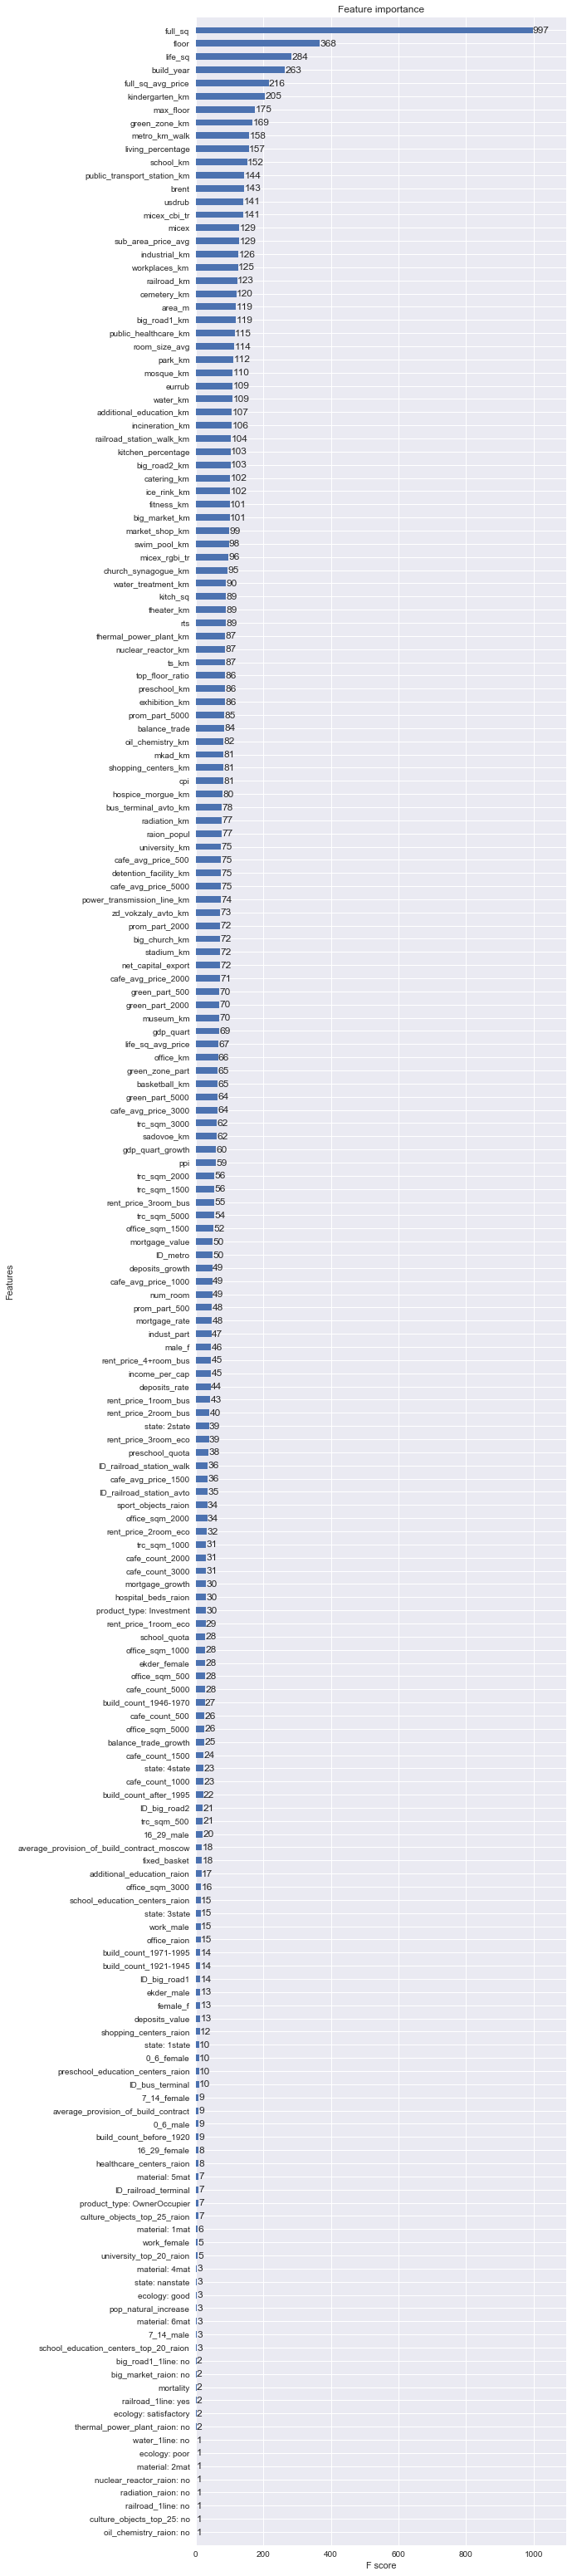

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8, 56))
xgb.plot_importance(val_model, height=0.5, ax=ax)

In [32]:
num_boost_rounds = val_model.best_iteration
model = xgb.train(xgb_params, dtrain, num_boost_round= num_boost_rounds)

In [33]:
dtest = xgb.DMatrix(test_x)
y_predict = model.predict(dtest)

In [34]:
results = np.exp(y_predict)
write_submission_file(results)